# Toronto Community Health Profile Segmentation by Neighborhood Level #
This is a pilot data science project for clustering neighborhood areas in Toronto characterized by their community health profile. The dataset used in this project is sourced from Ontario Community Health Profiles Partnership.

The page can be found here (http://www.ontariohealthprofiles.ca/)

Dataset is a collection of indicators from multiple data sources to describe the Toronto community health profile by neighborhood areas in Toronto. Indicators are categorized by 10 different categories which include socio-demographic, language spoken, ED care, prevention, hospital admissions, adult health and diseases, children and youth, birth rate, palliative care and etc.

**Problem Statement**: members of government agencies in Toronto Local Health Integration Network (TC LHIN), Minisitry of Health (MoH) and City of Toronto are interested in profiling the community health in Toronto at neighborhood level. Basically, this will help them to establish the strategic plan for resource allocation for future fiscal years.

**Potential Stakeholders**:
* Members from Toronto Local Health Integration Network (TC LHIN)
* Members from Ministry of Health and Long-term Care (MoHLTC)
* Members from City of Toronto

**Goal**: Provide the community health group comparison standards which are segemented at neighborhood level
Unlike hospital service providers (i.e., university teaching, pediatric, mental health), there is no clear peer group comparison standard established for community health service providers. Thus, we want to establish the community health profile segmenation at neighborhood level in Toronto. 

**Future Work**:

**Recommendation for Clients**:

In [1]:
# Import all libraries:
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn:
sns.set_style('whitegrid')
sns.set_context('poster')

## Data Loading ##
The dataset consists of information on various community health profile at a neighborhood level across Toronto area. The types of features include but not limited to 10 different types of indicator sources (i.e., population, socio-demographics, primary care, emergency care, adult health disease and etc.).

In [2]:
# Load training data: 
df = pd.read_excel('ochpp_train.xlsx', sheet_name='train')
# Map column names to lowercases
df.columns = map(str.lower, df.columns)

# Check the dataframe observations:
df.head()

,nh_id,nh_name,ward_id,ward_name,demo_pct_males,demo_pct_females,inc_avg_gross_income,inc_pct_lico_at,inc_pct_lim_at,inc_avg_fam_size,...,health_hosp_rate_1k,health_injury_rate_100,health_pc_mortality_rate_100,demo_birth_rate_1k,health_4_chronic_cond_rate_1k,health_diabetes_rate_100,health_asthma_rate_100,health_hbp_rate_100,health_mh_rate_100,health_copd_rate_100
0,1,West Humber-Clairville,2,Etobicoke North,0.505515,0.494485,82724.060150,0.137462,0.157645,3.608344,...,151.624350,18.723404,41.509434,29.611152,14.276676,18.240313,15.880395,29.872023,7.227160,6.836167
1,2,Mount Olive-Silverstone-Jamestown,1,Etobicoke North,0.490776,0.509224,68259.419662,0.217822,0.278446,3.708900,...,149.002476,18.414392,34.745763,42.018600,11.074320,18.428755,14.619216,28.466612,8.133318,6.579543
2,3,Thistletown-Beaumond Heights,1,Etobicoke North,0.495343,0.504657,80648.823529,0.146739,0.177866,3.450758,...,188.338301,22.488889,48.913043,32.098765,22.447839,17.709979,15.992921,31.797739,8.447794,9.261745
3,4,Rexdale-Kipling,2,Etobicoke North,0.489285,0.510715,77296.012270,0.158860,0.186866,3.240506,...,186.855555,22.595420,39.705882,32.824427,20.532592,17.458867,16.712992,31.170018,9.037934,10.466369
4,5,Elms-Old Rexdale,2,Etobicoke North,0.492390,0.507610,74574.712644,0.179270,0.232681,3.374749,...,161.560976,22.525970,23.636364,36.413341,15.219512,17.028070,19.024390,28.788080,8.886524,9.702315


# Feature Transformation #
**Feature encoding** is a process where features are encoded into right data format. Oridinal feature encoding will be applied on the likert scale measures which contains information about "order/magnitude" such as likelihood (i.e., score, level, etc.). 

**Stratification** is a process where numerical features get divided into group based on the specified range(s). 

In [3]:
# Ordinal Feature Encoding #
# Define the likert scale of ON Marginalization Index Features: avg_instability_scale, ... , avg_ethnic_scale
instability_map = {1: '1-least instable', 2: '2-little instable', 
                   3: '3-neutral instable', 4: '4-somewhat instable', 5: '5-most instable'}
deprivation_map = {1: '1-least deprived', 2: '2-little deprived', 
                   3: '3-neutral deprived', 4: '4-somewhat deprived', 5: '5-most deprived'}
dependency_map = {1: '1-least dependent', 2: '2-little dependent', 
                   3: '3-neutral dependent', 4: '4-somewhat dependent', 5: '5-most dependent'}
ethnic_map = {1: '1-least ethnic concentrated', 2: '2-little ethnic concentrated', 
                   3: '3-neutral ethnic concentrated', 4: '4-somewhat ethnic concentrated', 5: '5-most ethnic concentrated'}

# Encode features with each map:
df['instability_status'] = df['avg_instability_scale'].map(instability_map)
df['deprivation_status'] = df['avg_deprivation_scale'].map(deprivation_map)
df['dependency_status'] = df['avg_dependency_scale'].map(dependency_map)
df['ethnic_status'] = df['avg_ethnic_scale'].map(ethnic_map)

# Check the encoding:
print(df['instability_status'].head())

0     1-least instable
1    2-little instable
2     1-least instable
3    2-little instable
4    2-little instable
Name: instability_status, dtype: object


In [4]:
# Stratification #
# Define the proxy avg. gross income group bin size:
income_bins = [50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000]

# Generate new numerical group features based on binning:
df['avg_gr_inc_group'] = pd.cut(np.array(df['inc_avg_gross_income']), bins=income_bins)

# Check newly generated features:
print(df['avg_gr_inc_group'].head())

0    (80000, 90000]
1    (60000, 70000]
2    (80000, 90000]
3    (70000, 80000]
4    (70000, 80000]
Name: avg_gr_inc_group, dtype: category
Categories (8, interval[int64]): [(50000, 60000] < (60000, 70000] < (70000, 80000] < (80000, 90000] < (90000, 100000] < (100000, 110000] < (110000, 120000] < (120000, 130000]]


## Data Wrangling ##
In order to feed the existing data into the K-Means clustering, we are going to transform the dataframe into a table matrix.
This table matrix contains the number of features for each neighborhood in Toronto.

In [5]:
## Data Wrangling ##
# Copy a dataframe:
df_copy = df.copy()

# Drop unnecessary columns: avoid generating irrelevant dummy variables #
df_copy = df.drop(['nh_name','ward_name','ward_id','instability_status','deprivation_status',
                   'dependency_status','ethnic_status','avg_gr_inc_group'], axis=1)

# Create a new dataframe with dummy variables:
df_new = pd.get_dummies(df_copy, drop_first=True)

# Set index: nh_id
df_new = df_new.set_index('nh_id')

# Print the new dataframe:
df_new.head()

,demo_pct_males,demo_pct_females,inc_avg_gross_income,inc_pct_lico_at,inc_pct_lim_at,inc_avg_fam_size,inc_pct_econ_no_child,inc_pct_econ_w_child,inc_pct_lone_parents,inc_pct_one_person_house,...,demo_most_sponken_lang_Russian,demo_most_sponken_lang_Serbian,demo_most_sponken_lang_Somali,demo_most_sponken_lang_Spanish,demo_most_sponken_lang_Tagalog,demo_most_sponken_lang_Tamil,demo_most_sponken_lang_Tibetan,demo_most_sponken_lang_Ukrainian,demo_most_sponken_lang_Urdu,demo_most_sponken_lang_Vietnamese
nh_id,,,,,,,,,,,,,,,,,,,,,
1,0.505515,0.494485,82724.060150,0.137462,0.157645,3.608344,0.198630,0.552927,0.197385,0.173385,...,0,0,0,0,0,0,0,0,0,0
2,0.490776,0.509224,68259.419662,0.217822,0.278446,3.708900,0.141533,0.538319,0.275031,0.151316,...,0,0,0,0,0,0,0,0,0,0
3,0.495343,0.504657,80648.823529,0.146739,0.177866,3.450758,0.232955,0.496212,0.229167,0.176829,...,0,0,0,0,0,0,0,0,0,0
4,0.489285,0.510715,77296.012270,0.158860,0.186866,3.240506,0.227848,0.471971,0.249548,0.257812,...,0,0,0,1,0,0,0,0,0,0
5,0.492390,0.507610,74574.712644,0.179270,0.232681,3.374749,0.208417,0.430862,0.320641,0.193798,...,0,0,0,1,0,0,0,0,0,0


## K-Means Clustering ##

[[ 1.16057055 -1.16057055 -0.04629579 ... -0.22941573 -0.12038585
  -0.12038585]
 [ 0.36529172 -0.36529172 -1.07724355 ... -0.22941573 -0.12038585
  -0.12038585]
 [ 0.61169562 -0.61169562 -0.19420548 ... -0.22941573 -0.12038585
  -0.12038585]
 ...
 [-0.68255236  0.68255236 -1.10841828 ... -0.22941573 -0.12038585
  -0.12038585]
 [-0.3025219   0.3025219  -1.19233671 ... -0.22941573 -0.12038585
  -0.12038585]
 [-0.96740804  0.96740804  0.86222349 ... -0.22941573 -0.12038585
  -0.12038585]]


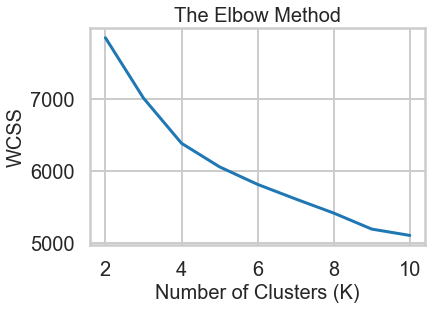

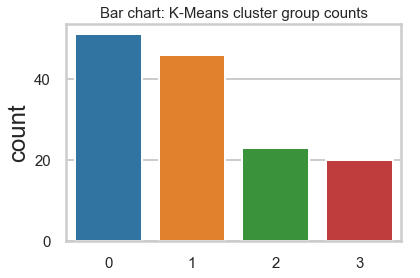

In [6]:
# Step 1: take the numpy matrix of feature(s) as X_cols: values within each column represent the feature.
X_cols = df_new.values

# Step 2: let's apply the feature scaling to standardize the range of values
sc_X = StandardScaler()
X_cols_std = sc_X.fit_transform(X_cols)

# Print the table matrix:
print(X_cols_std)

# Apply the K-Means cluster:
wcss=[]
for i in range(2,11):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X_cols_std)
    wcss.append(km.inertia_)
    
# Construct the Elbow method plot:
plt.figure()
plt.plot(range(2,11), wcss)
plt.title('The Elbow Method', fontsize=20)
plt.xlabel('Number of Clusters (K)', fontsize=20)
plt.ylabel('WCSS', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

# Fit K-Means cluster with the optimal K=4:
km = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_km = km.fit_predict(X_cols_std)
# Plot a bar chart: show number of points in each cluster
sns.countplot(y_km)
plt.title('Bar chart: K-Means cluster group counts', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Choosing the optimal K: The Silhouette Method ##
From the elbow method, it is hard to distinguish the optimal point where changes in WCSS is not so significant.
Therefore, we are going to apply the Silhouette method for assessing the optimal # of clusters. Silhouette score is computed on every single data point in every cluster. The Silhouette score ranges from -1 to +1 to indicate the level of reasonable groupings/structures.

n_clusters =  2 silhouette_avg_score 0.1402881017984617
n_clusters =  3 silhouette_avg_score 0.1394339328889071
n_clusters =  4 silhouette_avg_score 0.14160899582835257
n_clusters =  5 silhouette_avg_score 0.11566480752614093
n_clusters =  6 silhouette_avg_score 0.1290751058664082
n_clusters =  7 silhouette_avg_score 0.12877876217386483
n_clusters =  8 silhouette_avg_score 0.1239515851995264
n_clusters =  9 silhouette_avg_score 0.13334606987091013
n_clusters =  10 silhouette_avg_score 0.11791010835344916


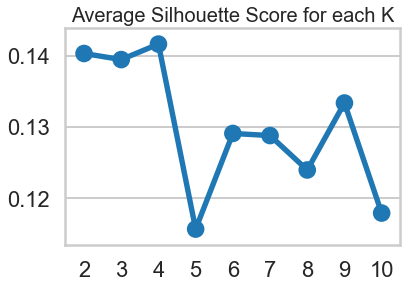

In [7]:
# Compute the Silhouette score for optimal K assessment:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

# Range of clusters: from 2 to 10;
rang_clust = list(range(2,11)) 
silhouette_scores = []

for n_clust in rang_clust:
    km = KMeans(n_clusters=n_clust, init='k-means++', random_state=0)
    km_labels = km.fit_predict(X_cols_std) #X_cols
    
    silhouette_avg = silhouette_score(X_cols_std, km_labels)
    silhouette_scores.append(silhouette_avg)
    print("n_clusters = ", n_clust,
         "silhouette_avg_score", silhouette_avg)

# Plot for average Silhouette score for each "K" cluster(s):
plt.figure()
plt.title('Average Silhouette Score for each K', fontsize=20)
sns.pointplot(x=rang_clust, y=silhouette_scores)
plt.show()

The optimal # of clusters (K=4) based on the given avg. score of silhouette (0.1416). Thus, Toronto community profile can be segmented based on 4 type of neighborhood groups.

For n_clusters = 2 The average silhouette_score is: 0.1402881017984617


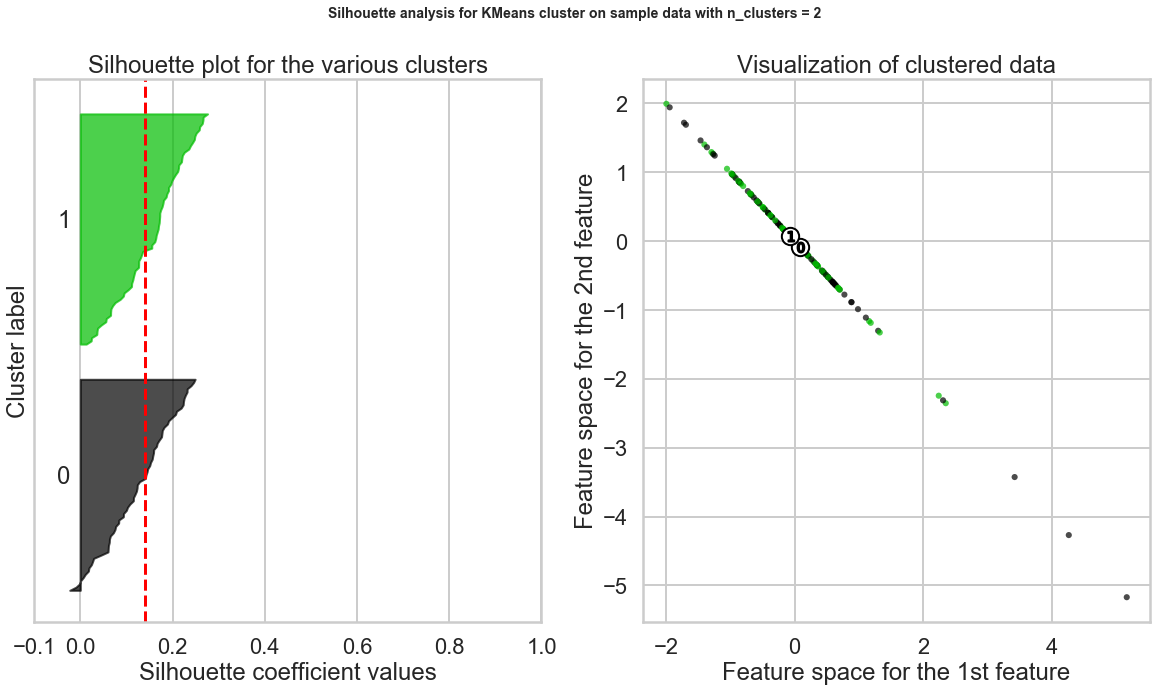

For n_clusters = 3 The average silhouette_score is: 0.1394339328889071


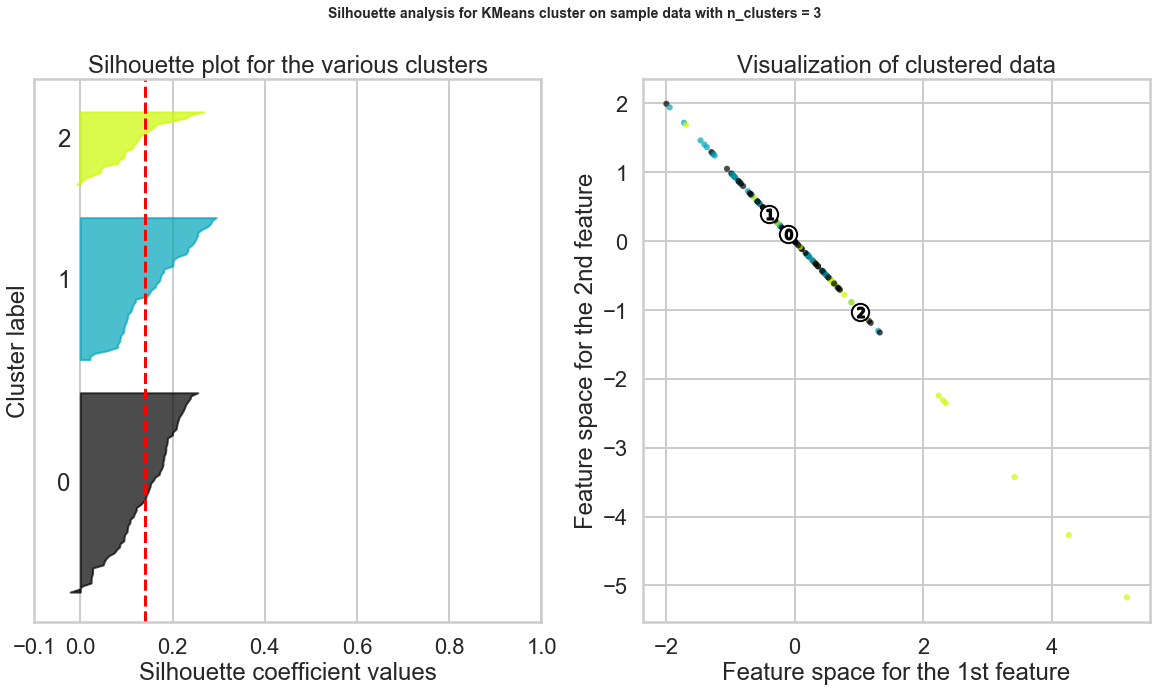

For n_clusters = 4 The average silhouette_score is: 0.14160899582835257


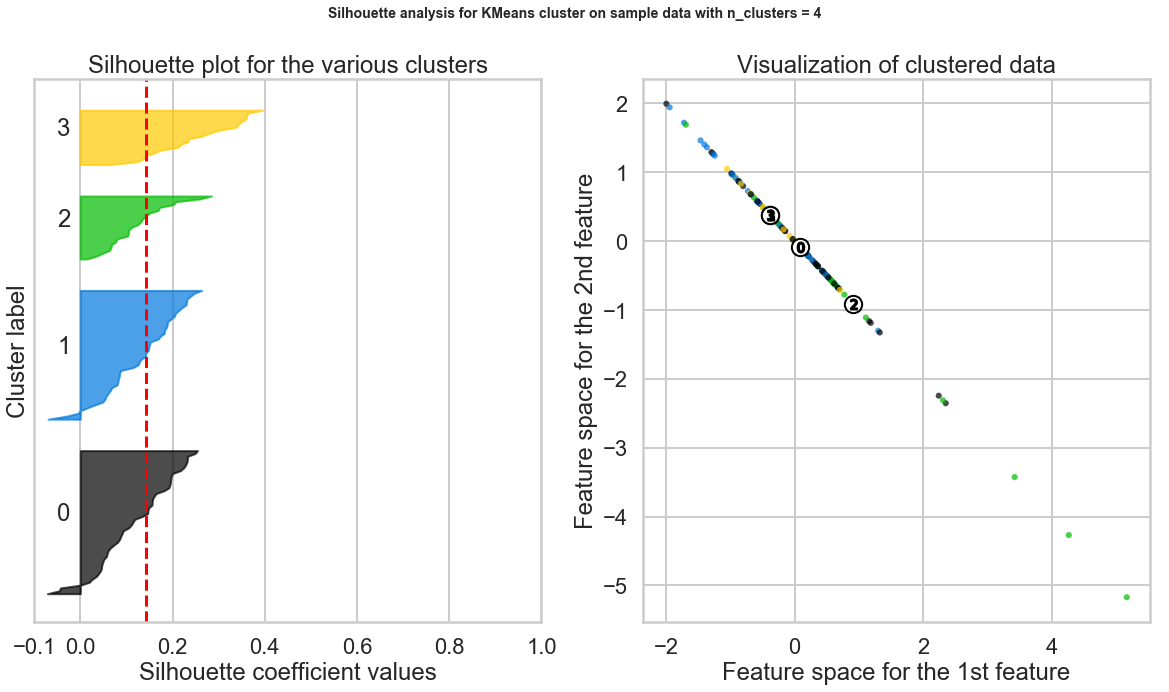

In [8]:
# Reduced range of clusters:
rang_clust = list(range(2,5)) 

# Silhouette and cluster plots for n_clusters:
for n_clust in rang_clust:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(20,10)
    
    # 1st sub-plot: Silhouette plot
    ax1.set_xlim([-0.1, 1])
    # Insert blank space between Silhouette plots: each cluster
    ax1.set_ylim([0, len(X_cols_std) + (n_clust + 1)*10])
    
    # Initialize the cluster with n_clust and a random number generator:
    km = KMeans(n_clusters=n_clust, init='k-means++', random_state=0)
    km_labels = km.fit_predict(X_cols_std)
    
    # Silhouette_score shows the average value: density and separation of formed cluster(s)
    silhouette_avg = silhouette_score(X_cols_std, km_labels)
    print("For n_clusters =", n_clust,
         "The average silhouette_score is:", silhouette_avg)
    
    # Compute the silhouette score for each sample:
    sample_silhouette_values = silhouette_samples(X_cols_std, km_labels)
    
    y_lower = 10
    for i in range(n_clust):
        # Aggreate the silhouette scores for samples belonging to
        # cluster i and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[km_labels == i]
        
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.spectral(float(i) / n_clust)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 
                          0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)
        
        # Label the silhouette plots with their cluster numbers in the middle:
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        # Compute the new y_lwoer for next plot
        y_lower = y_upper + 10 # 10 for the 0 samples;
    
    ax1.set_title('Silhouette plot for the various clusters')
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster label')
    
    # The vertical line for avrage silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color='red', linestyle='--')
    
    ax1.set_yticks([]) # clear the y-axis labels/ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd plot showing the actual formed clusters
    colors = cm.spectral(km_labels.astype(float) / n_clust)
    ax2.scatter(X_cols_std[:,0], X_cols_std[:,1], marker='.', s=150, lw=0, alpha=0.7, c=colors, edgecolor='k')
    
    # Labeling the clusters
    centers = km.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:,0], centers[:,1], marker='o',
               c='white', alpha=1, s=300, edgecolor='k')
    
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                   s=100, edgecolor='k')
        
    ax2.set_title('Visualization of clustered data')
    ax2.set_xlabel('Feature space for the 1st feature')
    ax2.set_ylabel('Feature space for the 2nd feature')
    
    plt.suptitle(('Silhouette analysis for KMeans cluster on sample data '
                'with n_clusters = %d' % n_clust),
               fontsize=14, fontweight='bold')
    plt.show()   

## Hierarchical Clustering ##

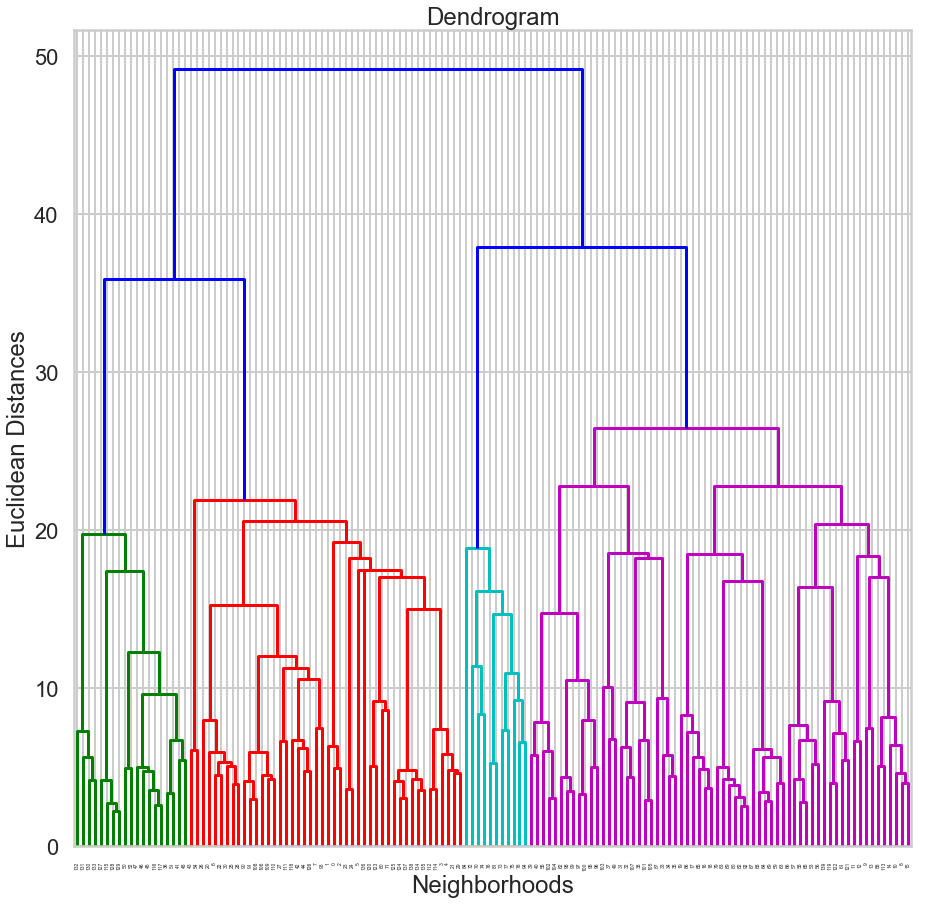

In [9]:
# Step 1: using the dendograms to find the optimal number of clusters (K)
import scipy.cluster.hierarchy as sch
fig = plt.figure(figsize=(15,15))
dn = sch.dendrogram(sch.linkage(X_cols_std, method = 'ward')) 
plt.title ('Dendrogram')
plt.xlabel('Neighborhoods')
plt.ylabel('Euclidean Distances')
plt.show() 

In [10]:
# Step 2: fitting hierarchical clustering to the dataset
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X_cols_std)

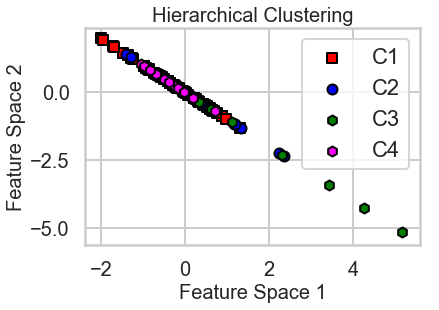

In [11]:
# Step 3: visualizing the clusters 
plt.scatter(X_cols_std[y_hc == 0, 0], 
            X_cols_std[y_hc == 0, 1], 
            s = 100, c = 'red', 
            marker='s', edgecolor='black',
            label = 'C1')
plt.scatter(X_cols_std[y_hc == 1, 0], 
            X_cols_std[y_hc == 1, 1], 
            s = 100, c = 'blue', 
            marker='o', edgecolor='black',
            label = 'C2')
plt.scatter(X_cols_std[y_hc == 2, 0], 
            X_cols_std[y_hc == 2, 1], 
            s = 100, c = 'green', 
            marker='h', edgecolor='black',
            label = 'C3')
plt.scatter(X_cols_std[y_hc == 3, 0], 
            X_cols_std[y_hc == 3, 1], 
            s = 100, c = 'magenta', 
            marker='h', edgecolor='black',
            label = 'C4')
plt.title('Hierarchical Clustering', fontsize=20)
plt.xlabel('Feature Space 1', fontsize=20)
xt = plt.xticks(fontsize=20)        
plt.ylabel('Feature Space 2', fontsize=20)
yt = plt.yticks(fontsize=20)
plt.legend()
plt.show()

## Visualize Clusters using PCA: K-Means ##
We have about 140 neighborhoods (data points) each containing 66 features (dimensions). Principal Component Analysis (PCA) will help us avoid the curse of dimensionality by reducing dimensions into a few dimensions (i.e., 2-D). 

In [12]:
# Apply K-Means clustering
km = KMeans(n_clusters=4, init='k-means++', random_state=0).fit(X_cols_std)
km_labels = km.labels_

# Apply PCA decomposition into 2 components:
pca = PCA(n_components=2) # specify into 2 components
X_cols_pca = pca.fit_transform(X_cols_std) # fit and transform into PCA components

# Create a PCA decomposed reduced dimensions and named two components:x, y
df_pca = pd.DataFrame(X_cols_pca)
df_pca.columns = ['X','Y']
df_pca.head()

,X,Y
0,-3.762540,0.989423
1,-4.544450,4.202996
2,-3.577174,2.269425
3,-1.843109,1.440193
4,-1.985163,3.273672


In [13]:
# Create a merged DataFrame: neighborhood name and label
df_merged = df_pca.merge(df['nh_name'].reset_index(), left_index=True, right_index=True).drop('index', axis=1)
# Bind predicted cluster label column:
df_merged['label'] = km_labels
# Print the dataframe:
df_merged.head()

,X,Y,nh_name,label
0,-3.762540,0.989423,West Humber-Clairville,0
1,-4.544450,4.202996,Mount Olive-Silverstone-Jamestown,0
2,-3.577174,2.269425,Thistletown-Beaumond Heights,0
3,-1.843109,1.440193,Rexdale-Kipling,0
4,-1.985163,3.273672,Elms-Old Rexdale,0


Text(0.5,1,'PCA Analysis [4 clusters] - K-Means Scatter Plot')

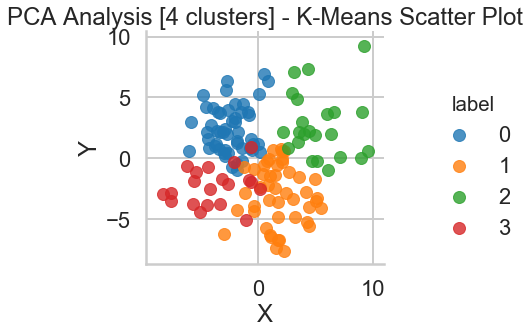

In [14]:
# Visualize the PCA cluster: scatter plot
sns.lmplot(x='X', y='Y', hue='label', data=df_merged, fit_reg=False)
plt.title('PCA Analysis [4 clusters] - K-Means Scatter Plot')

,X,Y,nh_name,label,nh_id,ward_id,ward_name,demo_pct_males,demo_pct_females,inc_avg_gross_income,...,health_diabetes_rate_100,health_asthma_rate_100,health_hbp_rate_100,health_mh_rate_100,health_copd_rate_100,instability_status,deprivation_status,dependency_status,ethnic_status,avg_gr_inc_group
0,-3.762540,0.989423,West Humber-Clairville,0,1,2,Etobicoke North,0.505515,0.494485,82724.060150,...,18.240313,15.880395,29.872023,7.227160,6.836167,1-least instable,4-somewhat deprived,3-neutral dependent,5-most ethnic concentrated,"(80000, 90000]"
1,-4.544450,4.202996,Mount Olive-Silverstone-Jamestown,0,2,1,Etobicoke North,0.490776,0.509224,68259.419662,...,18.428755,14.619216,28.466612,8.133318,6.579543,2-little instable,5-most deprived,2-little dependent,5-most ethnic concentrated,"(60000, 70000]"
2,-3.577174,2.269425,Thistletown-Beaumond Heights,0,3,1,Etobicoke North,0.495343,0.504657,80648.823529,...,17.709979,15.992921,31.797739,8.447794,9.261745,1-least instable,5-most deprived,5-most dependent,4-somewhat ethnic concentrated,"(80000, 90000]"
3,-1.843109,1.440193,Rexdale-Kipling,0,4,2,Etobicoke North,0.489285,0.510715,77296.012270,...,17.458867,16.712992,31.170018,9.037934,10.466369,2-little instable,4-somewhat deprived,4-somewhat dependent,3-neutral ethnic concentrated,"(70000, 80000]"
4,-1.985163,3.273672,Elms-Old Rexdale,0,5,2,Etobicoke North,0.492390,0.507610,74574.712644,...,17.028070,19.024390,28.788080,8.886524,9.702315,2-little instable,5-most deprived,2-little dependent,4-somewhat ethnic concentrated,"(70000, 80000]"


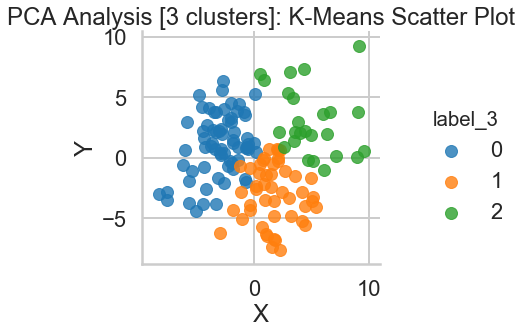

In [15]:
# Visualize the PCA cluster: scatter plot - 3 clusters
df_merged['label_3'] = KMeans(n_clusters=3, init='k-means++', random_state=0).fit(X_cols_std).labels_
sns.lmplot(x='X', y='Y', hue='label_3', data=df_merged, fit_reg=False)
plt.title('PCA Analysis [3 clusters]: K-Means Scatter Plot')

# Assume 3 clusters: label = label_3
df_merged['label'] = df_merged['label_3']
df_merged = df_merged.drop(['label_3'], axis=1)

# Reviewed the clustered data points by merge with other community health profile features:
df_review = df_merged.merge(df, on='nh_name')
df_review.head()

## Visualize Clusters using PCA: Hierarchical ##

In [16]:
# Apply Hierarchical clustering
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward')
hc_labels = hc.fit_predict(X_cols_std)

# Create a merged DataFrame: neighborhood name and label - Hierarchical Clustering
df_merged_hc = df_pca.merge(df['nh_name'].reset_index(), left_index=True, right_index=True).drop('index', axis=1)
# Bind predicted cluster label column:
df_merged_hc['label'] = hc_labels
# Print the dataframe:
df_merged_hc.head()

,X,Y,nh_name,label
0,-3.762540,0.989423,West Humber-Clairville,1
1,-4.544450,4.202996,Mount Olive-Silverstone-Jamestown,1
2,-3.577174,2.269425,Thistletown-Beaumond Heights,1
3,-1.843109,1.440193,Rexdale-Kipling,1
4,-1.985163,3.273672,Elms-Old Rexdale,1


Text(0.5,1,'PCA Analysis [4 clusters] - Hierarchical Scatter Plot')

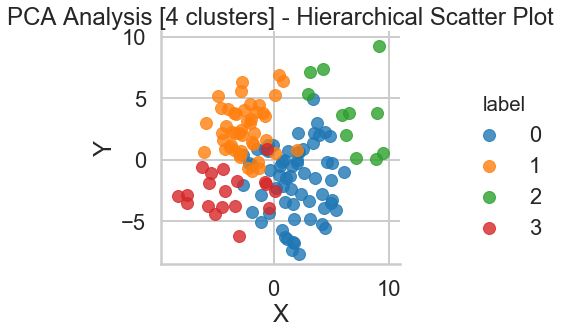

In [17]:
# Visualize the PCA cluster: scatter plot
sns.lmplot(x='X', y='Y', hue='label', data=df_merged_hc, fit_reg=False)
plt.title('PCA Analysis [4 clusters] - Hierarchical Scatter Plot')

,X,Y,nh_name,label,nh_id,ward_id,ward_name,demo_pct_males,demo_pct_females,inc_avg_gross_income,...,health_diabetes_rate_100,health_asthma_rate_100,health_hbp_rate_100,health_mh_rate_100,health_copd_rate_100,instability_status,deprivation_status,dependency_status,ethnic_status,avg_gr_inc_group
0,-3.762540,0.989423,West Humber-Clairville,0,1,2,Etobicoke North,0.505515,0.494485,82724.060150,...,18.240313,15.880395,29.872023,7.227160,6.836167,1-least instable,4-somewhat deprived,3-neutral dependent,5-most ethnic concentrated,"(80000, 90000]"
1,-4.544450,4.202996,Mount Olive-Silverstone-Jamestown,0,2,1,Etobicoke North,0.490776,0.509224,68259.419662,...,18.428755,14.619216,28.466612,8.133318,6.579543,2-little instable,5-most deprived,2-little dependent,5-most ethnic concentrated,"(60000, 70000]"
2,-3.577174,2.269425,Thistletown-Beaumond Heights,0,3,1,Etobicoke North,0.495343,0.504657,80648.823529,...,17.709979,15.992921,31.797739,8.447794,9.261745,1-least instable,5-most deprived,5-most dependent,4-somewhat ethnic concentrated,"(80000, 90000]"
3,-1.843109,1.440193,Rexdale-Kipling,0,4,2,Etobicoke North,0.489285,0.510715,77296.012270,...,17.458867,16.712992,31.170018,9.037934,10.466369,2-little instable,4-somewhat deprived,4-somewhat dependent,3-neutral ethnic concentrated,"(70000, 80000]"
4,-1.985163,3.273672,Elms-Old Rexdale,0,5,2,Etobicoke North,0.492390,0.507610,74574.712644,...,17.028070,19.024390,28.788080,8.886524,9.702315,2-little instable,5-most deprived,2-little dependent,4-somewhat ethnic concentrated,"(70000, 80000]"


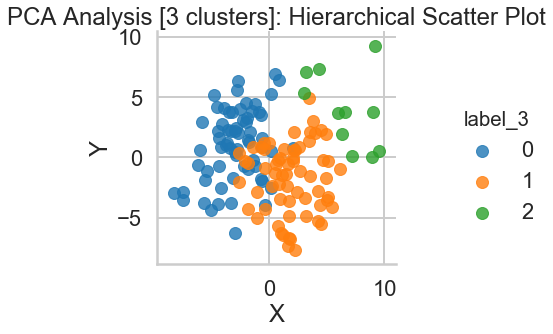

In [18]:
# Visualize the PCA cluster: scatter plot - 3 clusters
df_merged_hc['label_3'] = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward').fit_predict(X_cols_std)
sns.lmplot(x='X', y='Y', hue='label_3', data=df_merged_hc, fit_reg=False)
plt.title('PCA Analysis [3 clusters]: Hierarchical Scatter Plot')

# Assume 3 clusters: label = label_3
df_merged_hc['label'] = df_merged_hc['label_3']
df_merged_hc = df_merged_hc.drop(['label_3'], axis=1)

# Reviewed the clustered data points by merge with other community health profile features:
df_review_hc = df_merged_hc.merge(df, on='nh_name')
df_review_hc.head()

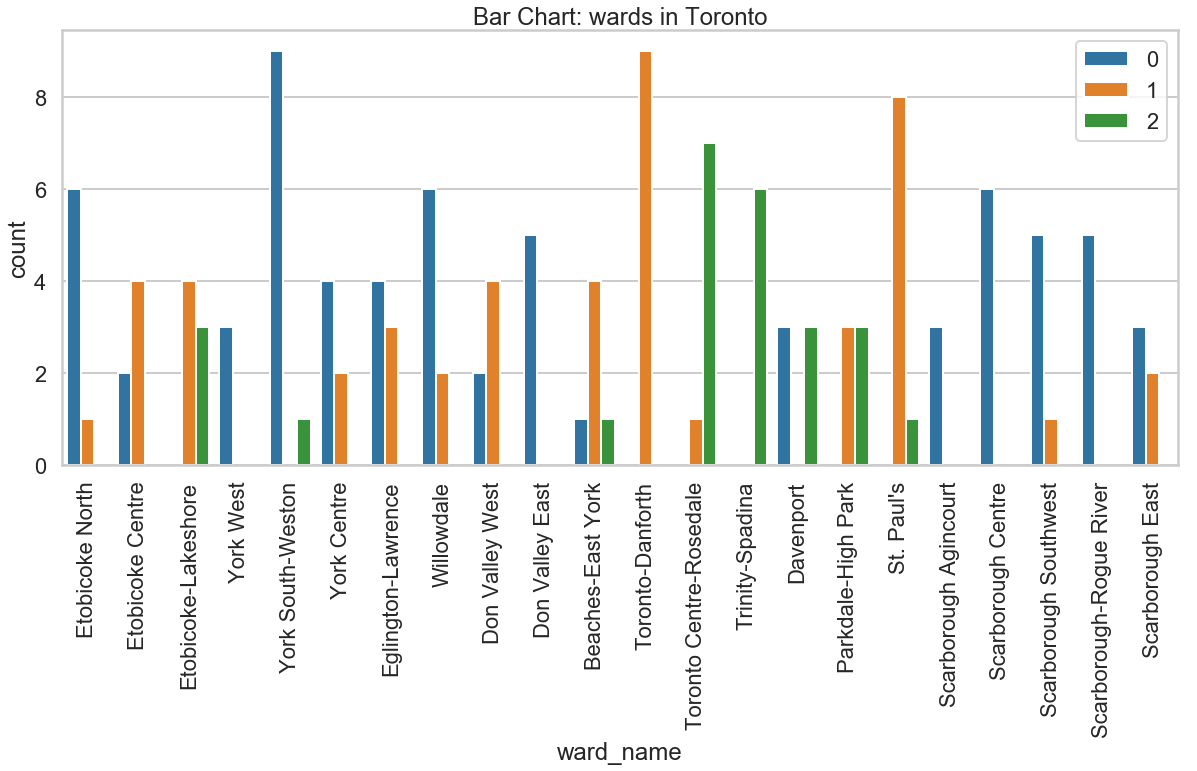

In [19]:
# Plot bar charts on City of Toronto Wards and cluster labels:
plt.figure(figsize=(20,8))
sns.countplot(x='ward_name', hue='label', data=df_review)
plt.title('Bar Chart: wards in Toronto')
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.show()

**Bar Chart Interpreation: at ward level in Toronto**

From the above bar charts, we can draw couple of interesting observations:
* York South-Weston ward was predominant on class 0 and small # of class 2.
* Toronto-Danforth ward was predominant on class 1 and no classes of 0 and 2.
* Toronto Centre-Rosedale ward was predominant on class 2 followed by class 1.
* Within Toronto, 18 wards were assigned on class 0 followed by 14 wards of class 1 and 8 wards of class 2.

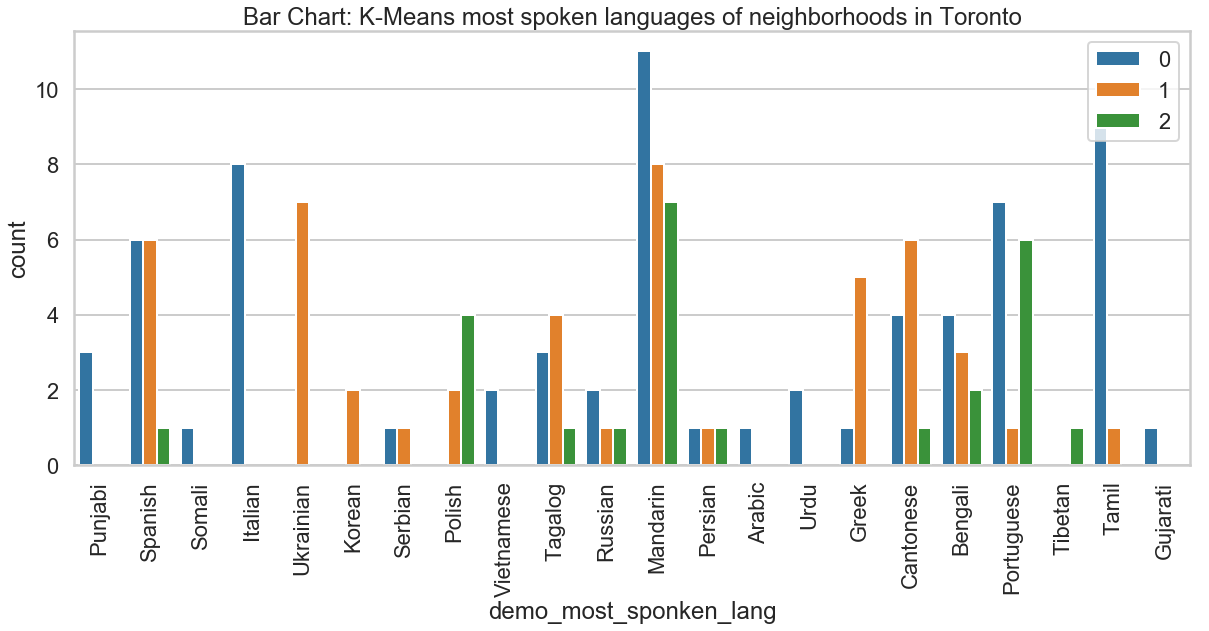

In [20]:
# Plot bar charts on most spoken languages and cluster labels:
plt.figure(figsize=(20,8))
sns.countplot(x='demo_most_sponken_lang', hue='label', data=df_review)
plt.title('Bar Chart: K-Means most spoken languages of neighborhoods in Toronto')
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.show()

**Bar Chart Interpreation: most spoken foreign language by neighborhood area(s)**

Note: Mandarin spoken area was predominant in Toronto neighborhood areas followed by Tamil, Portuguese, Cantonese, Spanish and etc.
* Mandarin spoken area(s), all three-neighborhood group(s) with label 0, 1 and 2 were found.
* Also, Portuguese, Spanish, Cantonese, Bengali, Tagalog, etc. spoken area(s) had neighborhoods with all 3 labels.
* Ukrainian and Korean spoken area(s) had only neighborhood group(s) with label 1
* Tibetan spoken area(s) had only neighborhood group(s) with label 2.
* Urdu, Arabic, Somali and Punjabi spoken area(s) had only neighborhood group(s) with label 0.

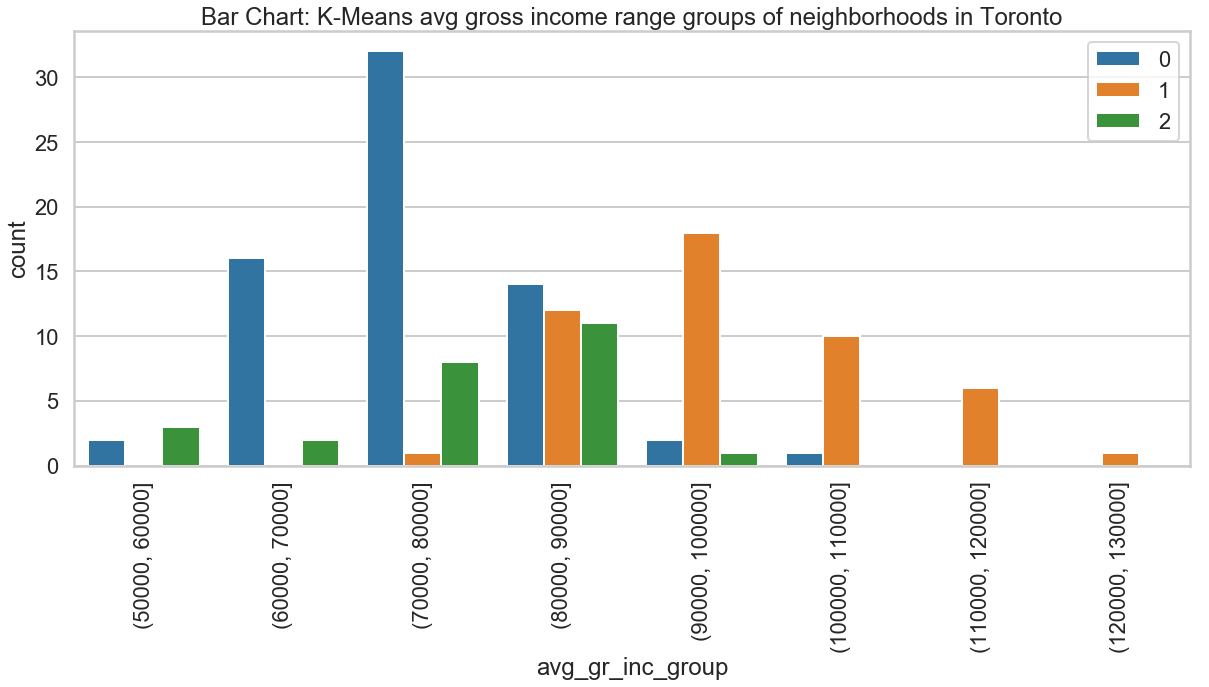

In [21]:
# Plot bar charts on avg. gross income group and cluster labels:
plt.figure(figsize=(20,8))
sns.countplot(x='avg_gr_inc_group', hue='label', data=df_review)
plt.title('Bar Chart: K-Means avg gross income range groups of neighborhoods in Toronto')
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.show()

**Bar Chart Interpreation: proxy average income range groups**
* Neighborhood group with label 0 has the lowest end of average income range in Toronto.
* Neighborhood group with label 2 has middle end of average income range in Toronto.
* Neighborhood group with label 1 has the highest end of average income range in Toronto.

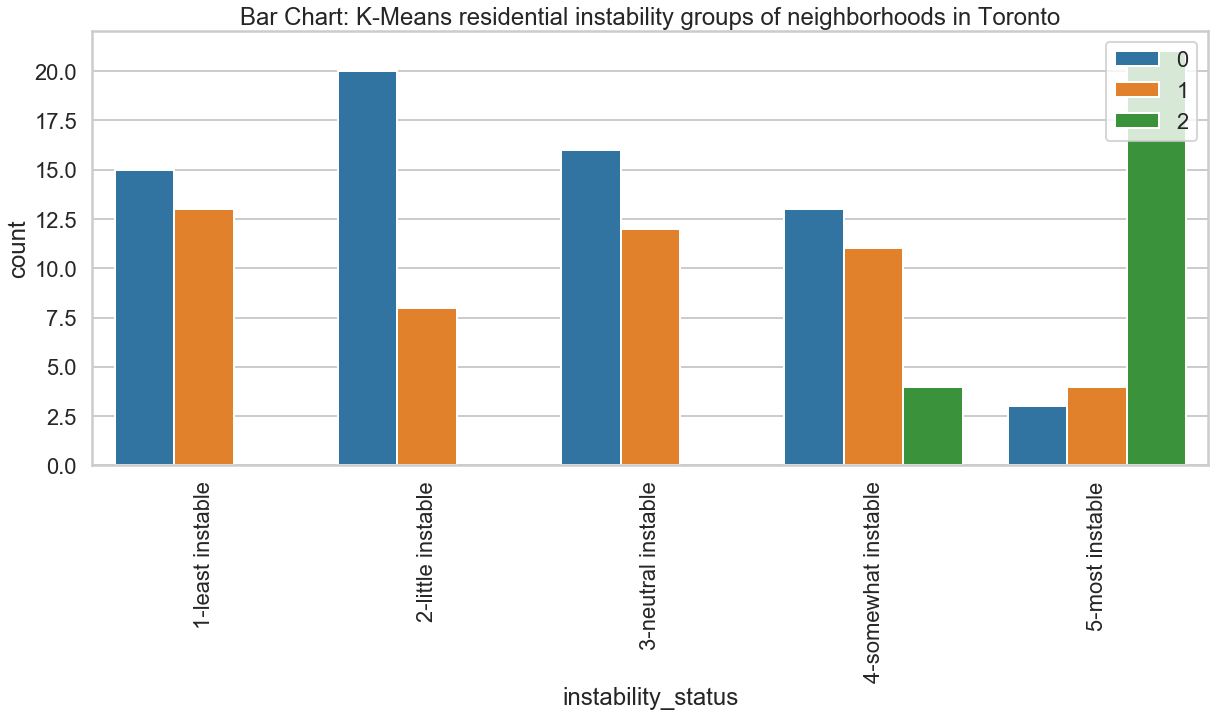

In [22]:
# Plot bar charts on residential instability and cluster labels:
plt.figure(figsize=(20,8))
sns.countplot(x='instability_status', hue='label', data=df_review)
plt.title('Bar Chart: K-Means residential instability groups of neighborhoods in Toronto')
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.show()

**Bar Chart Interpreation: residential instability groups in Toronto**
* The least residential instable area(s) are assigned with neighborhood group label 0 and 1.
* The most residential area(s) are assigned with neighborhood group label 0 and 2.

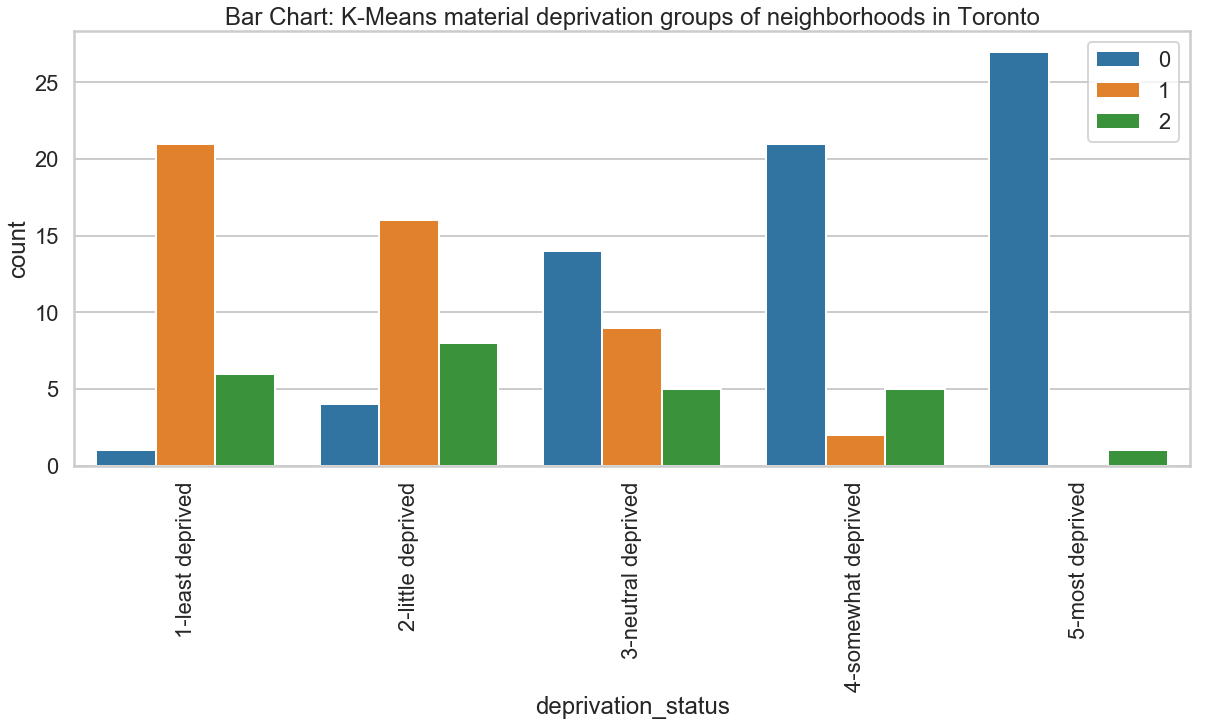

In [23]:
# Plot bar charts on material deprivation and cluster labels:
plt.figure(figsize=(20,8))
sns.countplot(x='deprivation_status', hue='label', data=df_review, 
              order=['1-least deprived', '2-little deprived','3-neutral deprived', '4-somewhat deprived', '5-most deprived'])
plt.title('Bar Chart: K-Means material deprivation groups of neighborhoods in Toronto')
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.show()

**Bar Chart Interpreation: material deprivation groups in Toronto**
* The least material deprived area(s) are predominantly assigned with neighborhood group label 1 and followed by label 2.
* The most material deprived area(s) are predominantly assigned with neighborhood group label 0 and followed by label 2.

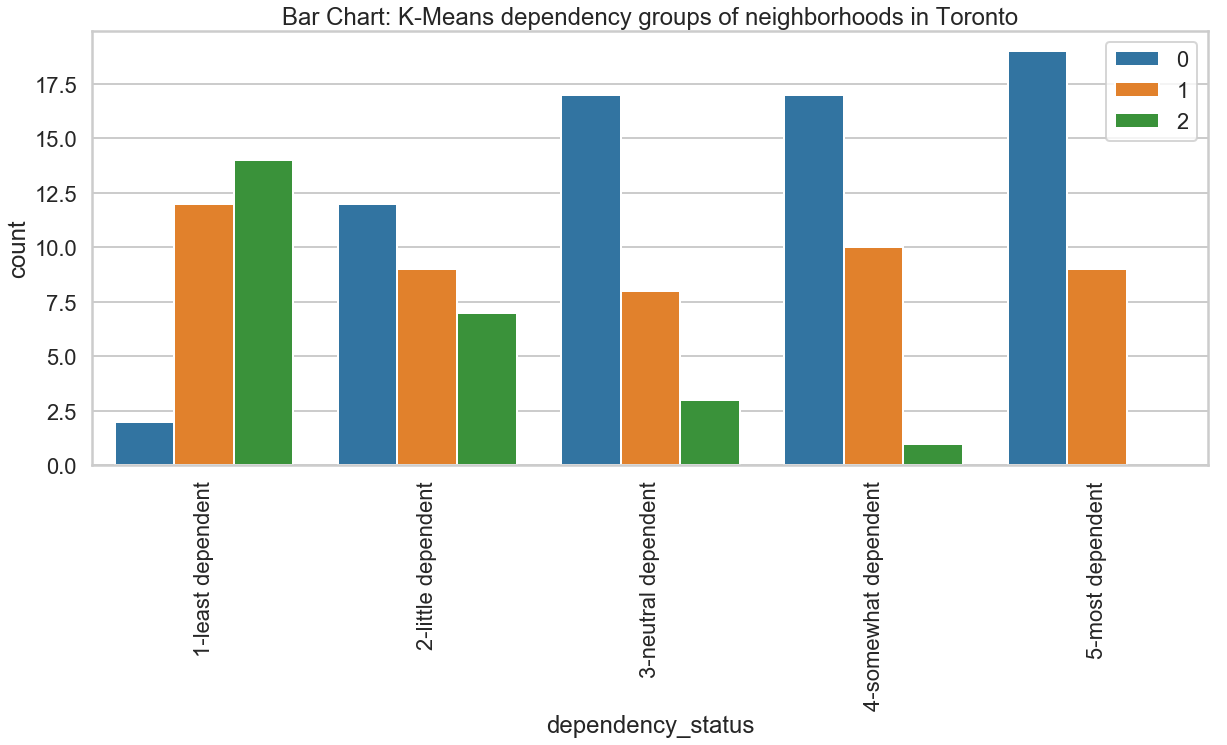

In [24]:
# Plot bar charts on dependency and cluster labels:
plt.figure(figsize=(20,8))
sns.countplot(x='dependency_status', hue='label', data=df_review,
             order=['1-least dependent', '2-little dependent','3-neutral dependent', '4-somewhat dependent', '5-most dependent'])
plt.title('Bar Chart: K-Means dependency groups of neighborhoods in Toronto')
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.show()

**Bar Chart Interpreation: dependency groups in Toronto**
* The least dependent area(s) are predominantly assigned with neighborhood group label 2 followed by label 1 and 0.
* The most dependent area(s) are predominantly assigned with neighborhood group label 0 and followed by label 1.

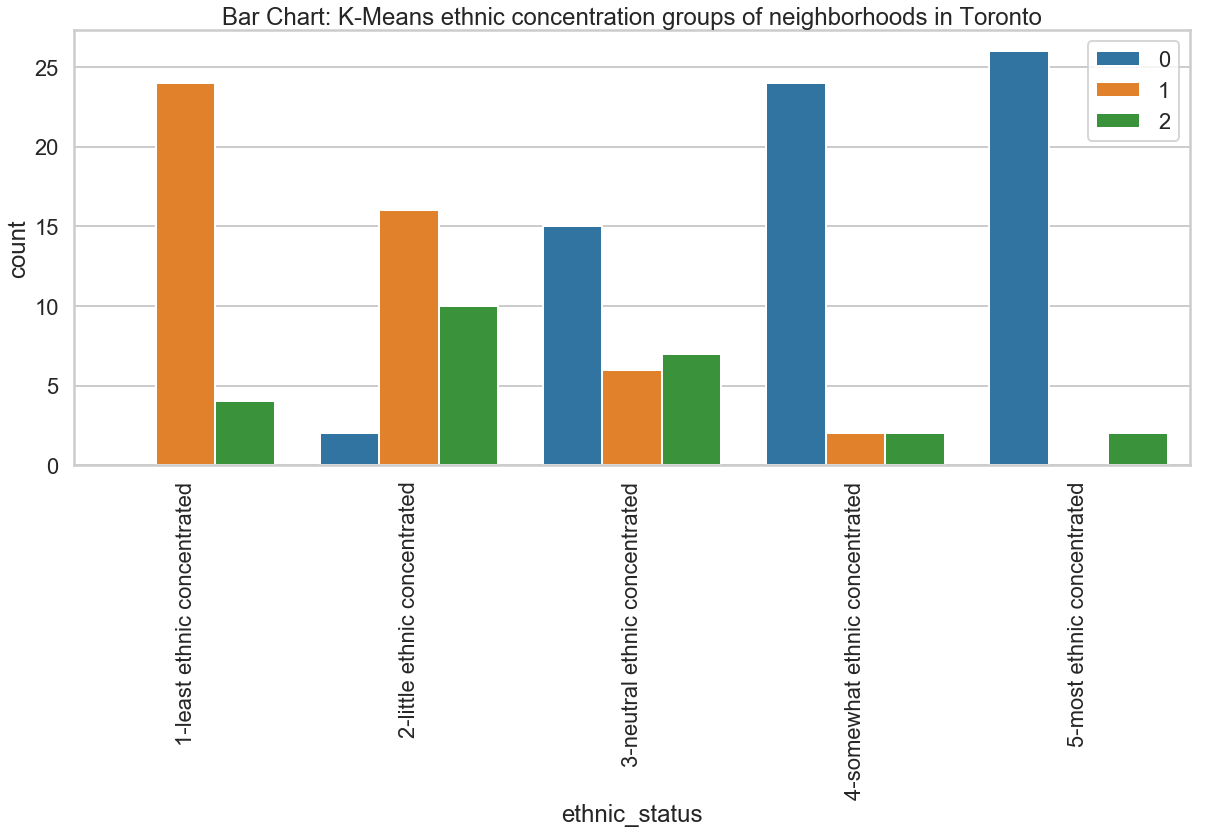

In [25]:
# Plot bar charts on ethnic concentration and cluster labels:
plt.figure(figsize=(20,8))
sns.countplot(x='ethnic_status', hue='label', data=df_review,
             order=['1-least ethnic concentrated', '2-little ethnic concentrated','3-neutral ethnic concentrated',
                    '4-somewhat ethnic concentrated', '5-most ethnic concentrated'])
plt.title('Bar Chart: K-Means ethnic concentration groups of neighborhoods in Toronto')
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.show()

**Bar Chart Interpreation: ethnic concentration status in Toronto**
* The least immigrants concentrated area(s) are assigned with neighborhood group label 1 and 2.
* The most immigrants concentrated area(s) are assigned with neighborhood group label 0 and 2.
* The neutral degree of immigrant concentrated area(s) is assigned with neighborhood group label 0, 1 and 2.

In [26]:
# Check the lengh of matrix w.r.t: columns
len(X_cols_std[0])

66

## Initialize a new PCA model ##

We are going to used the explained variance component to plot the optimal # of clusters determined by PCA model!

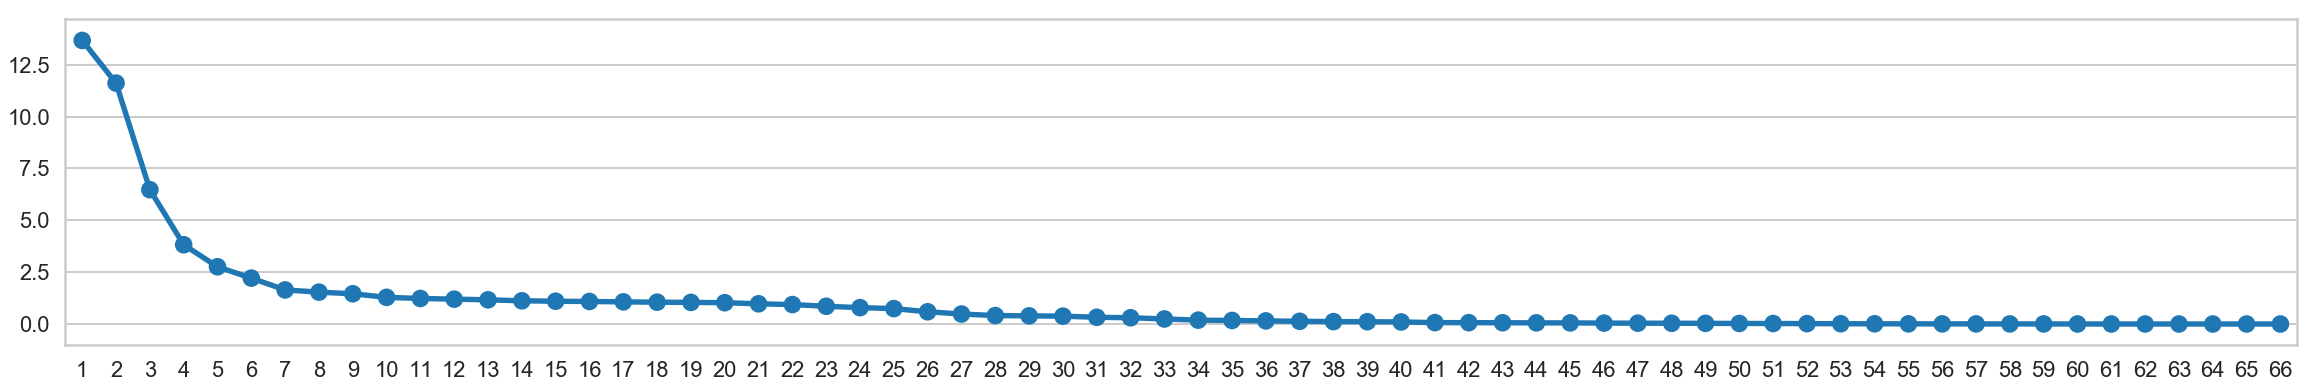

In [27]:
# Initialize: new PCA model
pca = sklearn.decomposition.PCA()
pca.fit(X_cols_std)

# Compute the explained variance
pca.explained_variance_

# Plot a explained variance:
plt.figure(figsize=(40,6))
sns.pointplot(x=list(range(1,67)), y=pca.explained_variance_)

From the above explained variance plot, optimum elbow point for # of pca components seems n=4. Thus, PCA algorithm suggests that the optimal number of components should be 4 instead of 2!